<a href="https://colab.research.google.com/github/eekaiboon/gen_ai/blob/main/samoyed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install -Uqq fastbook

In [58]:
import fastbook
fastbook.setup_book()

In [59]:
from fastbook import *
from fastai.vision.widgets import *

In [60]:
ims = search_images_ddg('samoyed dog')
len(ims)

200

In [61]:
dest = 'images/samoyed.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/samoyed.jpg')

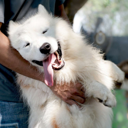

In [62]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [63]:
dog_breeds = ['samoyed','chow chow']
path = Path('dogs')

In [64]:
if not path.exists():
  path.mkdir()
  for breed in dog_breeds:
    dest = (path/breed)
    dest.mkdir(exist_ok=False)
    results = search_images_ddg(f'{breed} dog')
    download_images(dest, urls=results)

In [65]:
fns = get_image_files(path)
fns

(#365) [Path('dogs/samoyed/8bc773ca-3d90-4b4a-988f-f2d5d6dc3620.jpg'),Path('dogs/samoyed/1d33da1f-dd3f-4b7d-a974-5223faa1f9cb.jpg'),Path('dogs/samoyed/fd346019-082a-433b-a601-9ac0875db4b6.jpeg'),Path('dogs/samoyed/43e8562a-9674-4fff-921e-2cb24d69f5e2.jpg'),Path('dogs/samoyed/6f48bd18-1a5d-462a-ab58-3cafd34f1425.jpg'),Path('dogs/samoyed/07145183-7eee-4aa3-9916-0f29f29a8392.jpeg'),Path('dogs/samoyed/d81d696c-0907-4b0f-8a18-518b1787b34d.jpg'),Path('dogs/samoyed/e7924296-9b4d-47f8-823d-560f5fa28f06.jpg'),Path('dogs/samoyed/e0e1dcf8-a8b3-472c-90f6-9936cafd5036.png'),Path('dogs/samoyed/8e504373-8119-4ff7-867a-368e129d7d21.jpg')...]

In [66]:
failed = verify_images(fns)
failed

(#0) []

In [67]:
failed.map(Path.unlink)

(#0) []

In [68]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [69]:
dls = dogs.dataloaders(path)

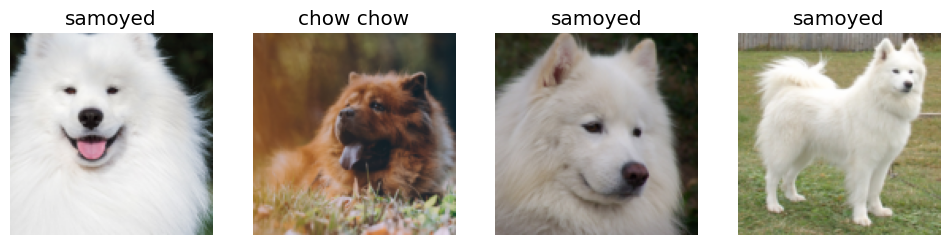

In [70]:
dls.valid.show_batch(max_n=4, nrows=1)

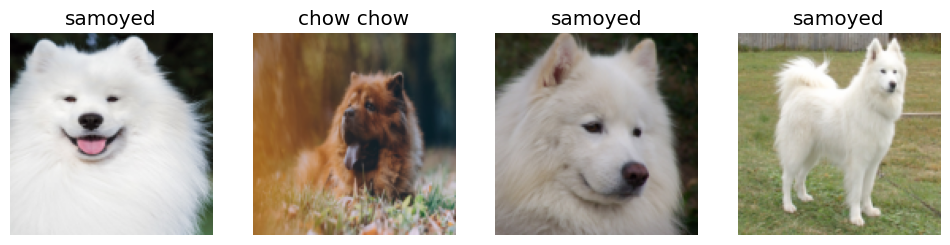

In [71]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

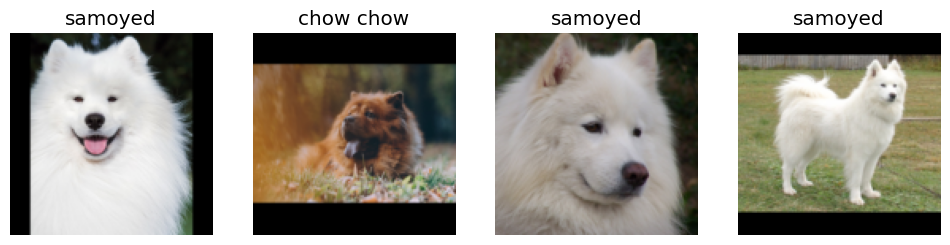

In [72]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

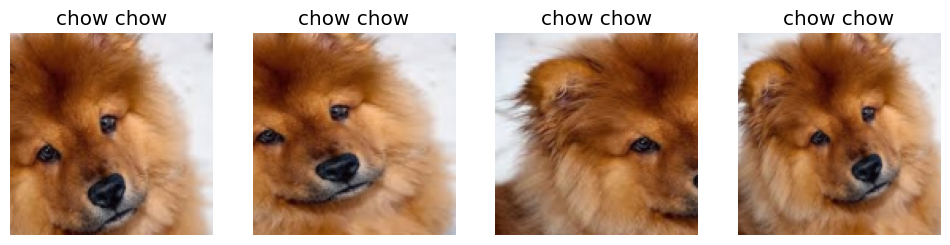

In [73]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

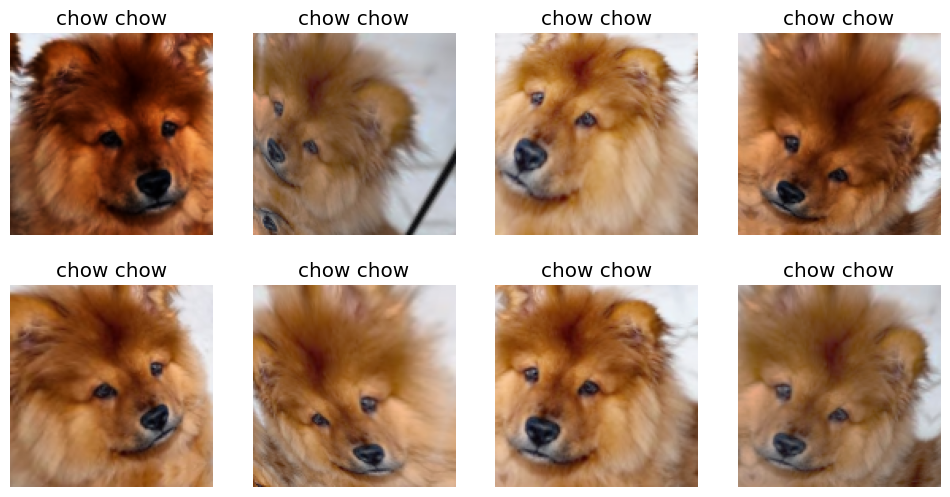

In [74]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [75]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [76]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.036870,0.116126,0.095890,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.090330,0.010886,0.000000,00:05
1,0.093852,0.007941,0.000000,00:05
2,0.069133,0.008342,0.000000,00:05
3,0.054301,0.007160,0.000000,00:05


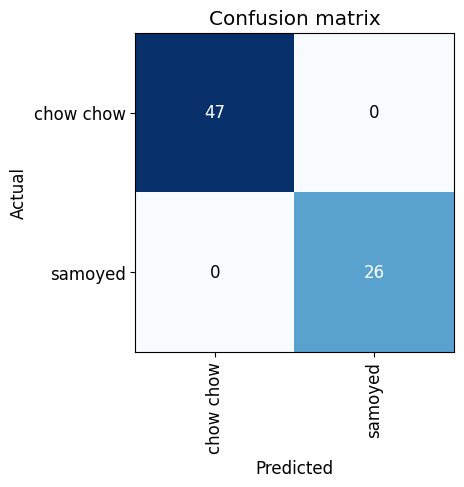

In [77]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [78]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [79]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [80]:
learn.export('models/samoyed_classifier.pkl')

In [81]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable


In [82]:
#|export
from fastai.vision.all import *
import gradio as gr

In [83]:
#|export
learn = load_learner('models/samoyed_classifier.pkl')

In [84]:
#|export
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [85]:
#|export
title = "Samoyed Classifier"
examples = ['test/samoyed_1.jpg']

demo = gr.Interface(fn=predict,
                    inputs="image",
                    outputs="label",
                    title=title,
                    examples=examples)
demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


# Export

In [86]:
!pip install nbdev

Defaulting to user installation because normal site-packages is not writeable


In [89]:
from nbdev.export import nb_export
nb_export('samoyed_classifier.ipynb', lib_path='.', name='app')

In [90]:
%%writefile requirements.txt
fastcore
fastai

Overwriting requirements.txt
